In [1]:
import spintrace
import numpy as np
import pandas as pd
from astropy.table import vstack
import matplotlib.pylab as plt
plt.rcParams['font.family'] = 'serif'
import matplotlib.gridspec as gridspec

### Downloading the fits tables from the database requires a CSV table containing candidate images's metadata and could take time

In [2]:
# # Initialize the downloader with CSV and output path
# downloader = spintrace.Downloader(
#     csv_file='Hektor/table_624-Hektor20000624.csv', # Path to your metadata file
#     path_to_save_fits='Hektor/fits_tables/',     # Folder to save the FITS files
#     max_workers=5,                               # Number of parallel downloads
#     verbose=False
# )

# downloader.download_fits()

### If not known, you can retrieve some information from ssocard webpage using the following method.

Note that, if g-r colors are not provided, it calculates the values from other available colors, as follows:
- (g-i)-(r-i)
- (g-z)-(r-z)
- (v-r)-(v-g)

It calculates all three values with error bars, if they exist, and averages the results to print the inal value. 

In [3]:
info = spintrace.get_object_information_ssocard(target='Hektor')
info['color_indices']['r-i']

{'value': 0.2842,
 'error': 0.0053,
 'facility': 'SMSS',
 'filters': ['SkyMapper/SkyMapper.r', 'SkyMapper/SkyMapper.i'],
 'ref': 'Sergeyev+2022'}

### From here on I assume that fits tables are already in your local directory

In [4]:
fits_directory = 'Hektor/fits_tables/'
fits_files = spintrace.get_files(fits_directory)
colors = {'g-r': 0.61,'r-i':0.2842} # g-r from schemel et al 2021
color_errs = {'g-r': 0.01,'r-i':0.0053}
v_tol = 2

In [5]:
# The first time you run this cell will take a few minutes to download the ephemeris from JPL Horizons, but it saves it as .ephem_cache,
# so next runs will just read it from there. If you wanna force the download it again, you can set use_cache=False.
body = spintrace.Body(
    name="Hektor", 
    ephem_start_date="2018-01-01", 
    ephem_end_date="2025-07-01", 
    step="4h", 
    location="I41",
    use_cache=True
)

In [6]:
# Here you initialize the class, to be able to perform the following calculations. 
mpa = spintrace.MultiPhotometryAnalysis(
    fits_files=fits_files,
    body=body,
    colors=colors,
    color_errs=color_errs,
    v_tol=v_tol
)

In [7]:
# This cell can take many minutes in your first run if check_close_stars=True. Because it will query Gaia catalog and return all Gaia stars inside a radius of 8" (default)
# It will save partial files every 100 queries in case something get wrong (e.g., you jupyter crashes), it will resume the download from the partial files. 
# Once it finishes, it will delete the partial file and save the final gaia_closeby_stars.fits files. It will use this file in next runs. 
mpa.run_analysis(check_close_stars=True)

2025-10-03 11:42:13,056 - INFO - Found existing Gaia stars final file: Hektor/gaia_closeby_stars.fits	 Skipping Gaia query and loading existing results...
2025-10-03 11:42:13,185 - INFO - Removing rows where a Gaia star is ≤ 4" from the asteroid's expected position.


Filtered table has 1089 rows after filtering.


In [8]:
# Initializes the PLots class
plots = spintrace.Plots(table = mpa.reduced_table,
                    ast_name=body.name,fontsize=16)

In [9]:
string = f"{body.name}/plots/{body.name}"
string

'Hektor/plots/Hektor'

# General view and phase curve fitting in each filter

In [10]:
f_list = ['g','r','i'] # Filters that you might have data
string = 'Hektor/plots/Hektor' # the directory and start of file names to save the plots, first create the directory. 
phase_bin = int(2) # this is the value of solar phase angles to be use to bin data during the phase curve linear fit. 
# Binning helps to mitigate rotational amplitude effects in phase curve fit.
model = 'linear'# it could be shevchenko as well, linear is the default

for item in f_list:
    # creates the general plots of reduced mag as a function of time (JD corrected by light time).
    plots.general(filter_code=item,
              show_yerr=True,
              show_color=True,
              save_path=string+'_general_'+item+'.jpg')
    # Fit the phase curve and create the plots
    popt, fit_label, popt2, fit_label_binned = mpa.fit_phase_curve(filter_code=item,phase_bin=phase_bin,model=model)
    plots.phase_curve(filter_code=item,
                  popt=popt, 
                  fit_label=fit_label, 
                  popt2=popt2, 
                  fit_label_binned=fit_label_binned,
                  show_yerr=True,
                  show_color=True,
                  show_fig = False,
                  save_path=string+'_phase_curve_'+item+'_'+model+'.jpg')

Figure saved to Hektor/plots/Hektor_general_g.jpg
Figure saved to Hektor/plots/Hektor_phase_curve_g_linear.jpg
Figure saved to Hektor/plots/Hektor_general_r.jpg
Figure saved to Hektor/plots/Hektor_phase_curve_r_linear.jpg
Figure saved to Hektor/plots/Hektor_general_i.jpg
Figure saved to Hektor/plots/Hektor_phase_curve_i_linear.jpg


In [11]:
# Here you will take a look in the Hektor_phase_curve*jpg files and decide which of the models' results you wanna use. 
# I usually take the binned values, but is good to look if the model is actually representing well your data, otherwise go back and change your phase_bin value
# Here you will generate a new table with reduced magnitude corrected by the solar phase effects.
table_g = mpa.fit_phase_curve(filter_code='g',model='linear',H=7.83,B=0.04)
table_i = mpa.fit_phase_curve(filter_code='i',model='linear',H=7.11,B=0.04)
table_r = mpa.fit_phase_curve(filter_code='r',model='linear',H=7.36,B=0.04)

merged_table = vstack([table_g, table_r, table_i])
len(merged_table)

Fit result for g filter using original data and linear model:
Original data linear fit: H = 7.83, beta = 0.04
Fit result for i filter using original data and linear model:
Original data linear fit: H = 7.11, beta = 0.04
Fit result for r filter using original data and linear model:
Original data linear fit: H = 7.36, beta = 0.04


1026

In [12]:
# Here is a plot to see if your linear fit worked for all the three filters. If they mismatch, you can go back and change parameters until they roughtly match each other.
plots.general(x_column='phase_angle',
              y_column='phase_corrected_mag',
              show_yerr=True,
              show_color=True,
              color_column='filter_code',
              table=merged_table,
              save_path=string+'_corrected_by_phase.jpg')

Figure saved to Hektor/plots/Hektor_corrected_by_phase.jpg


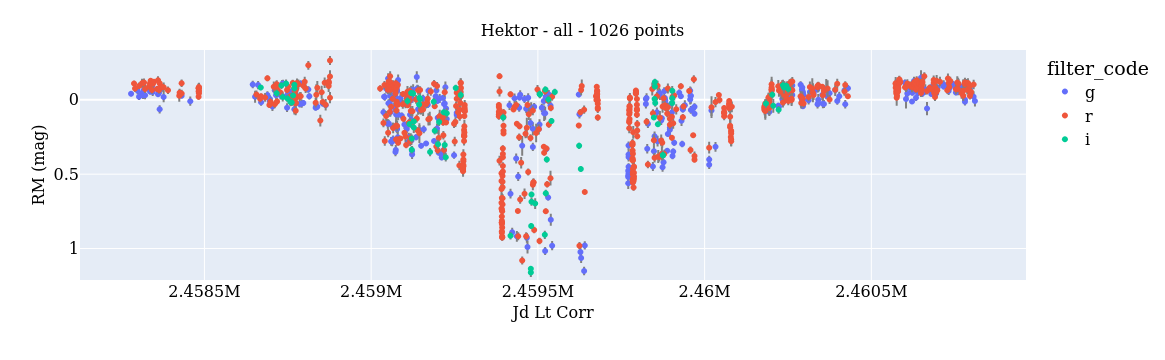

In [13]:
# Here is a plot to see if your linear fit worked for all the three filters. If they mismatch, you can go back and change parameters until they roughtly match each other.
plots.general(x_column='jd_lt_corr',
              y_column='phase_corrected_mag',
              show_yerr=True,
              show_color=True,
              color_column='filter_code',
              table=merged_table,
              # save_path=string+'_corrected_by_phase.jpg'
             )

# Periodic search - all data

In [14]:
P_ref=6.92
min_freq = [3.0,2]
max_freq = [4.0,6]
n_terms =  [2,2]
delta_t =  [None,None]# Not a fit, just to plot a vertical line in the periodogram
peaks =    [False,False]
n_shuffle = [10,None]
samples_per_peak = [None,None]
freq = []
power = []
f_win = []
p_win = []
rotational_analysis =[]

for i in range(len(n_terms)):
    ra = spintrace.RotationalAnalysis(table=merged_table,
                                               P_ref=P_ref,
                                               f_min=min_freq[i],
                                               f_max=max_freq[i],
                                               n_term=n_terms[i]) 
    f,p,fr,po = ra.lomb_scargle_fit(asteroid=body.name, 
                                         filter_code=None,
                                         use_magerr=True,
                                         delta_t = delta_t[i],
                                         legend=True,
                                         samples_per_peak=samples_per_peak[i],
                                         peaks = peaks[i],
                                         n_shuffle = n_shuffle[i],
                                         use_window_function=True,
                                         y_max = 0.4,
                                         save_path=string+'_periodogram'+str(i)+'.jpg'
                                        )
    freq.append(f)
    power.append(p)
    f_win.append(fr)
    p_win.append(po)
    rotational_analysis.append(ra)

/home/flavia/.local/lib/python3.13/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:134: RuntimeWarning:

invalid value encountered in divide

/home/flavia/.local/lib/python3.13/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:134: RuntimeWarning:

invalid value encountered in divide



In [17]:
rot = rotational_analysis[0]
round(24/rot.best_freq,5)

np.float64(6.92025)

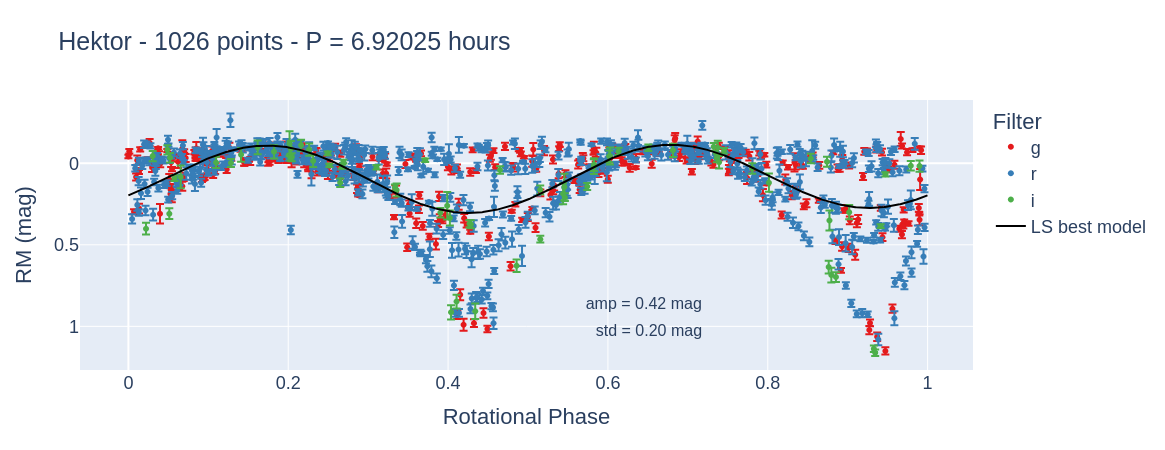

In [18]:
model_params = rot.compute_phased_model(JD = np.array(rot.table['jd_lt_corr']), 
                                                        mag = np.array(rot.table['phase_corrected_mag']),
                                                        best_freq = rot.best_freq ,
                                                        epoch0=2458279.952216666 # 2018-06-10 10:51:12 first valid data point
                                                       )
            
df = plots.folded_lightcurve(asteroid=body.name,
                                table = rot.table,
                                filter_codes=np.array(rot.table['filter_code']),
                                JD=np.array(rot.table['jd_lt_corr']),  
                                model_params=model_params, 
                                corrected_mag=np.array(rot.table['phase_corrected_mag']),
                                mag_err=np.array(rot.table['mag_cal_err']),
                                best_freq = rot.best_freq, 
                                save_path=string+'_lightcurve_folded.jpg', 
                                epoch_zero = 2458279.952216666, # 2018-06-10 10:51:12 first valid data point
                                show_fig=True)

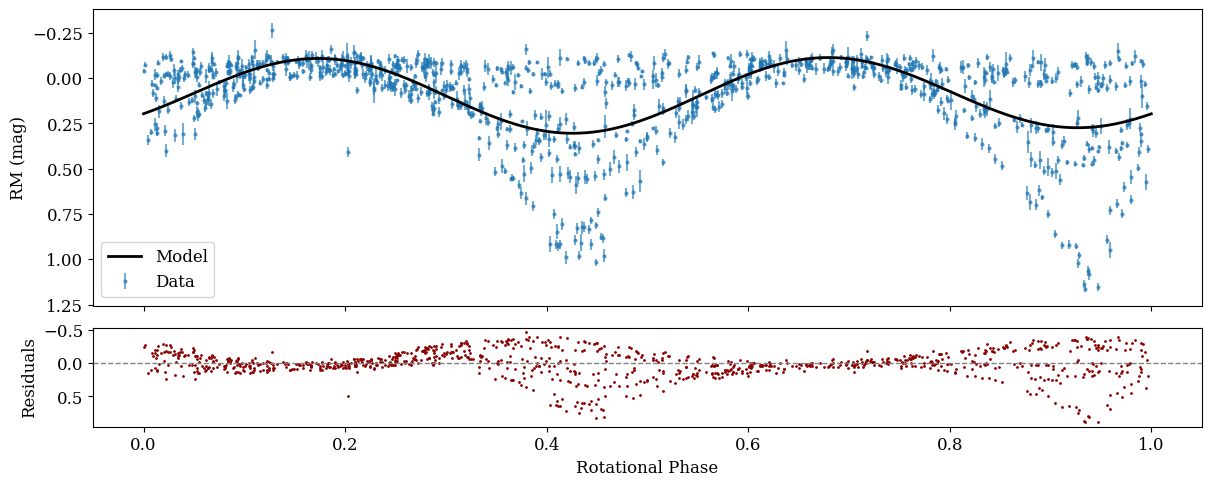

In [19]:
df['residuals'] = df['Magnitude']-df['model_mag']
plots.plot_folded_lightcurve_with_residuals(df,save_path=string+'folded_light_curve_with_residuals.jpg',fontsize=12)

In [20]:
def paper_periodogram(broad, zoomed, xmin, xmax, best_freq, save_path=None,error=0.04,ylim=1,FF=10):
    """
    Create a three-panel periodogram plot with window function overlay.

    Parameters
    ----------
    broad : array-like
        2D array where broad[0] = frequency, broad[1] = power, broad[3] = window function.
    zoomed : array-like
        2D array, same structure as broad, but zoomed-in version.
    xmin, xmax : list of float
        List of x-axis min and max for the 3 subplots.
    best_freq : float
        Best-fit frequency in cycles/day.
    save_path : str or None
        If provided, saves the figure to this path.
    """
    
    from matplotlib.ticker import FormatStrFormatter
    
    # Setup figure
    fig = plt.figure(figsize=[12, 3.75])
    gs = gridspec.GridSpec(3, 1, hspace=0.30)

    def add_subplot(row, xlim, band_text):
        ax = fig.add_subplot(gs[row, 0])
        ax.plot(24 / broad[0], broad[1], color='r', alpha=1.0,label='Data')
        ax.axhline(0, color='k')
        ax.set_xlim(xlim)
    
        if row == 2:
            ax.axvline(24 / best_freq - error, linestyle=':', color='k')
            ax.axvline(24 / best_freq + error, linestyle=':', color='k')
            ax.set_xlabel('Rotational Period (hours)', fontsize=FF)
    
        if row == 0:
            ax.fill_between([xmin[1], xmax[1]], 0, 1, color='blue', alpha=0.2)
            ax.axhline(0.06,linestyle='--', color='darkblue',label='Shuffle test')
        elif row == 1:
            ax.fill_between([xmin[2], xmax[2]], 0, 1, color='blue', alpha=0.2)
            ax.axhline(0.06,linestyle='--', color='darkblue')
    
        ax.set_ylabel('LS power', fontsize=FF)
        ax.set_yticks(np.linspace(0, ylim, 4))
        ax.tick_params(labelsize=FF)
        ax.text(0.015, 0.85, band_text, transform=ax.transAxes, fontsize=FF, ha='center', va='center')
    
        if row == 0:
            ax.legend(fontsize=FF, loc='upper right', ncol=2)
    
        # 👉 Do this last so nothing overrides it
        ax.set_ylim(0, ylim)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


    # Add subplots A, B, C
    add_subplot(0, (xmin[0], xmax[0]), 'A)')
    add_subplot(1, (xmin[1], xmax[1]), 'B)')
    add_subplot(2, (xmin[2], xmax[2]), 'C)')
    
    if save_path:
        plt.savefig(save_path, format='jpg', dpi=300)
    plt.show()

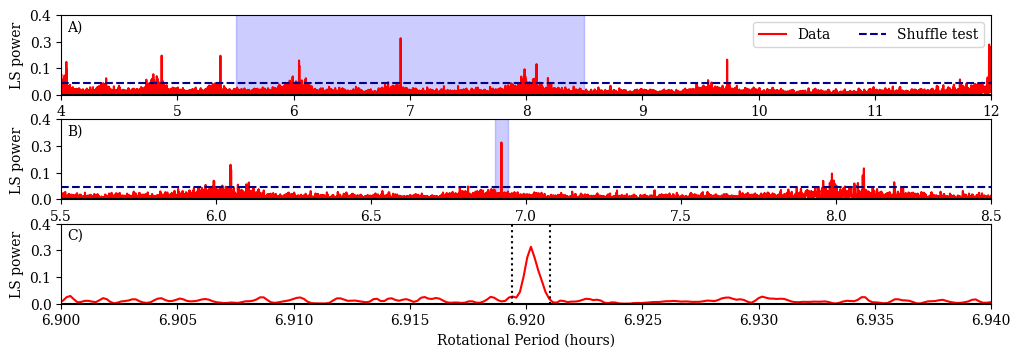

In [21]:
data1= np.column_stack((freq[0], power[0], f_win[0], p_win[0]))
data1 = data1.T
data0= np.column_stack((freq[1], power[1], f_win[1], p_win[1]))
data0 = data0.T

paper_periodogram(
    broad=data0,
    zoomed=data1,
    xmin=[4,5.5,6.9],
    xmax=[12,8.5,6.94],
    best_freq=ra.best_freq,
    error = 0.0008,
    ylim = 0.4,
    FF=10,
    save_path=string+'paper.jpg'
)

# Single orbit analysis

This is useful for targets that present rotational light curve amplitude variation yearly, as for Hektor. 
The following lines: separate the data by orbits, search for the period and fit the rotational model in each sub-set of the data set (all filters together here). 
Then it plots all phased data and their respective models together, so you can see the light curve amplitude variation. 

In [22]:
# The gap_threshold is given in days (default is 90), it the gap used to separate one orbit from another.
orbit_tables = spintrace.split_table_by_time_gaps(merged_table, jd_column='jd_lt_corr', gap_threshold=90)
print(len(orbit_tables),'orbits found')

7 orbits found


In [24]:
# Here you will search for the best period in each subset and built a rotational light curve model for each one. 
# nt corresponds to the Fourier terms to be used in the LombScargle search, the list must have the same lenght as the orbits defined above. 
# You can run as many times you need until you get a satisfactory model for the orbit light curve, is an interactive procedure here. 
nt = [2,2,2,9,2,2,2]

rot, tab, folded_models,freq,power= spintrace.RotationalAnalysis.per_sample_analysis(asteroid=body.name,
                                    table=orbit_tables, # previously defined orbits
                                    nterms=nt,
                                    P_ref=6.92, # published rotational period in hours
                                    f_min=3.443, # minimum and maximum frequencies allowed to be explored during the search in cycles/day
                                    f_max=3.49,
                                    delta_t=(0.0014*3), # This error bar (hour) is not used in the search, it is plotted in the periodogram so you can have an idea of the width your peak has
                                    samples_per_peak=200, # This is a keyword of the LombScargle method, it means you will sample the main peak 300 times, and sometimes can reveal hidden frequencies. 
                                    use_window_function=False,
                                    # n_shuffle = 10,
                                    save_path=string)

Figure saved to Hektor/plots/Hektor_A_corrected_by_phase.jpg
Figure saved to Hektor/plots/Hektor_B_corrected_by_phase.jpg
Figure saved to Hektor/plots/Hektor_C_corrected_by_phase.jpg
Figure saved to Hektor/plots/Hektor_D_corrected_by_phase.jpg
Figure saved to Hektor/plots/Hektor_E_corrected_by_phase.jpg
Figure saved to Hektor/plots/Hektor_F_corrected_by_phase.jpg
Figure saved to Hektor/plots/Hektor_G_corrected_by_phase.jpg


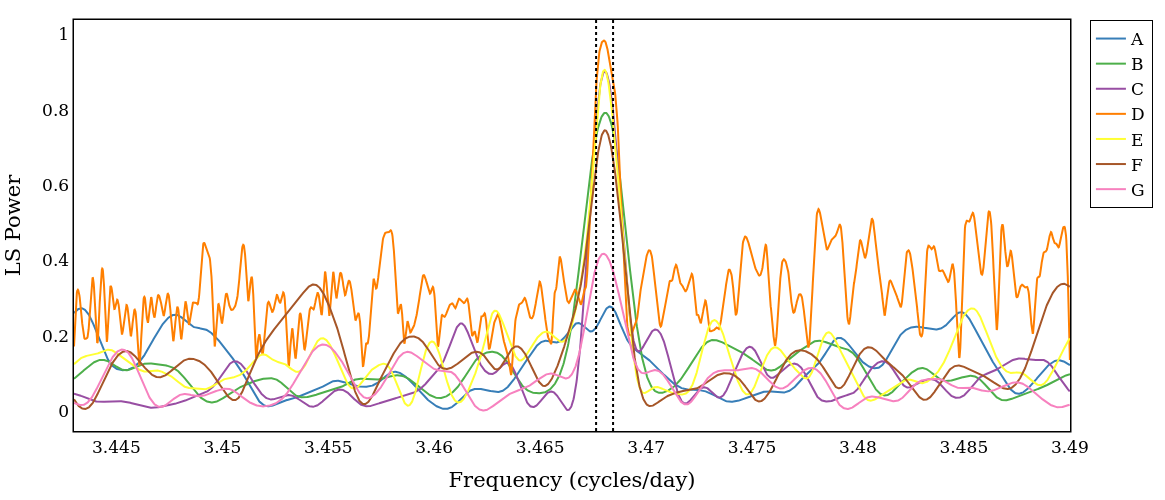

In [25]:
plots.plot_all_periodograms(frequency=freq,
                            power=power,
                            best_frequency=rot['E'].best_freq,
                            error=0.0008,
                            bkg=False,
                            fontsize=plots.fontsize+5,
                            save_path=string)

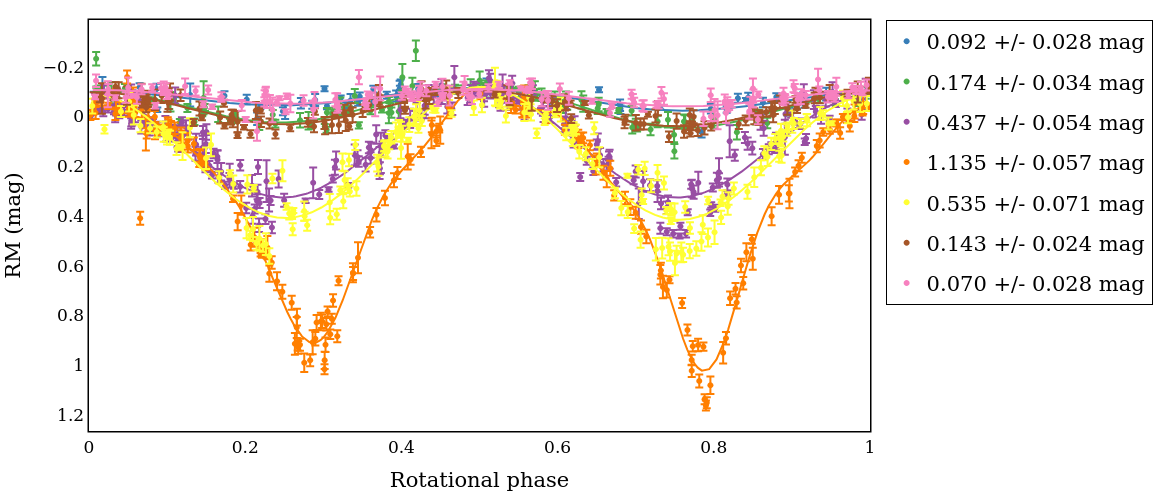

In [26]:
# Here you get an interactive plot will all fits together. You can download it as png by clicking in the first button in the right upper corner.
# To activate and deactivate the visualization of one model, just click on it in the legend.
plots.plot_all_folded_samples(folded_models,fontsize=plots.fontsize+5,save_path=string,rot_dict=rot)

In [27]:
# Here we merge all orbits together again. Now containing a column mag_corr_by_rot, wich is basically magnitude minus the rotational model in their respective orbits.
final_table = vstack([tab['A'],tab['B'],tab['C'],tab['D'],tab['E'],tab['F'],tab['G']])
len(final_table)

1026

In [28]:
# H and Beta error estimations using multiple simulations.
abs_mags, abs_mags_err, slope, slope_err = [],[],[],[]
for item in f_list:
    mask = final_table['filter_code'] == item
    df = final_table[mask].to_pandas()
    df.to_csv(f'Hektor_{item}.csv')
    
    x_data = df['phase_angle']
    y_data = df['mag_corr_by_rot']
    y_noise = df['mag_cal_err']
    
    h, h_err, beta, beta_err = mpa.simulate_phase_curve(x_data, y_data, y_noise)
    abs_mags.append(h) 
    abs_mags_err.append(h_err)
    slope.append(beta) 
    slope_err.append(beta_err)

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 19838.59it/s]


In [29]:
for i in range(3):
    print(f"H = {round(abs_mags[i], 4)} +/- {round(abs_mags_err[i], 4)} mag")
    print(f"Beta = {round(slope[i], 4)} +/- {round(slope_err[i], 4)} \n")

H = 7.8441 +/- 0.0033 mag
Beta = 0.04 +/- 0.0004 

H = 7.356 +/- 0.0044 mag
Beta = 0.0394 +/- 0.0005 

H = 7.1092 +/- 0.0125 mag
Beta = 0.041 +/- 0.0016 



In [30]:
# Then we fit the phase curves again to obtain H and G values free of any rotational amplitude variations
for item in f_list:
    # creates the general plots of reduced mag as a function of time (JD corrected by light time).
    plots.general(filter_code=item,
              show_yerr=True,
              show_color=True,
              table=final_table,
              y_column='mag_corr_by_rot',
              save_path=string+'_general_'+item+'_corr.jpg')
    # Fit the phase curve and create the plots
    popt, fit_label, popt2, fit_label_binned = mpa.fit_phase_curve(filter_code=item,
                                                                   phase_bin=phase_bin,
                                                                   table=final_table,
                                                                   model=model)
    plots.phase_curve(filter_code=item,
                  popt=popt, 
                  fit_label=fit_label, 
                  popt2=popt2, 
                  fit_label_binned=fit_label_binned,
                  show_yerr=True,
                  show_color=True,
                  show_fig = False,
                  table=final_table,
                  y_column='mag_corr_by_rot',
                  save_path=string+'_phase_curve_'+item+'_'+model+'_corr.jpg')

Figure saved to Hektor/plots/Hektor_general_g_corr.jpg
Figure saved to Hektor/plots/Hektor_phase_curve_g_linear_corr.jpg
Figure saved to Hektor/plots/Hektor_general_r_corr.jpg
Figure saved to Hektor/plots/Hektor_phase_curve_r_linear_corr.jpg
Figure saved to Hektor/plots/Hektor_general_i_corr.jpg
Figure saved to Hektor/plots/Hektor_phase_curve_i_linear_corr.jpg


In [31]:
popt, fit_label, popt2, fit_label_binned = mpa.fit_phase_curve(filter_code='r',
                                                                   phase_bin=phase_bin,
                                                                   table=final_table,
                                                                   model=model)

plots.phase_curve(filter_code='r',
                  popt=popt, 
                  fit_label=fit_label, 
                  popt2=popt2, 
                  fit_label_binned=fit_label_binned,
                  show_yerr=True,
                  show_color=True,
                  show_fig = False,
                  table=final_table,
                  y_column='mag_corr_by_rot',
                  ylim=[9,7],
                  bkg=False,
                  bkg_data=True,
                  label=False,
                  width = 1050,
                  height =325,
                  save_path=string+'_phase_curve_r_'+model+'_corr2.jpg')

Figure saved to Hektor/plots/Hektor_phase_curve_r_linear_corr2.jpg


In [32]:
# Check the 'Hektor_phase_curve*corr.jpg' plots or results from simulation and chose with values you wanna use to correct data for solar phase angle
table_g_corr = mpa.fit_phase_curve(table=final_table,filter_code='g',model='linear',H=7.8441,B=0.03998)
table_i_corr = mpa.fit_phase_curve(table=final_table,filter_code='i',model='linear',H=7.109, B=0.041)
table_r_corr = mpa.fit_phase_curve(table=final_table,filter_code='r',model='linear',H=7.356, B=0.03939)

Fit result for g filter using original data and linear model:
Original data linear fit: H = 7.8441, beta = 0.03998
Fit result for i filter using original data and linear model:
Original data linear fit: H = 7.109, beta = 0.041
Fit result for r filter using original data and linear model:
Original data linear fit: H = 7.356, beta = 0.03939


In [33]:
# join everything again
merged_table_corr = vstack([table_g_corr, table_r_corr, table_i_corr])
len(merged_table_corr)

1026

Figure saved to Hektor/plots/Hektor_corrected_by_phase_and_rotation.jpg


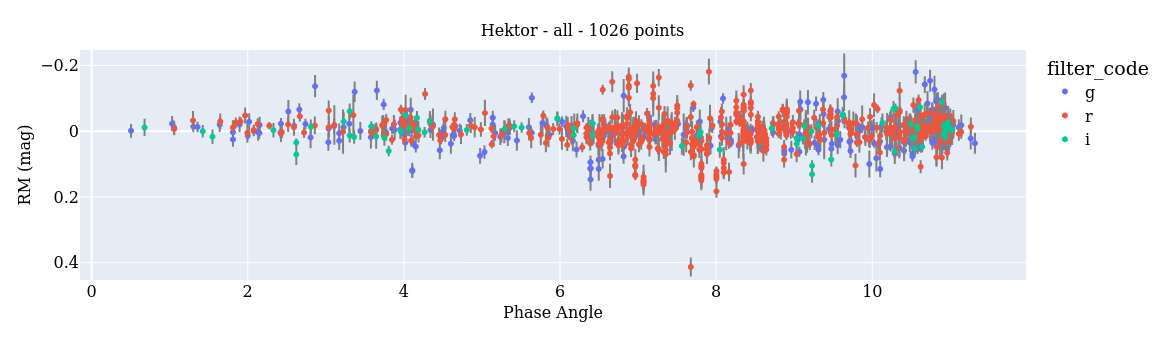

In [34]:
# Now you can see the residuals after discounting the rotational effects (orbit by orbit) and the solar phase angle effects. 
plots.general(x_column='phase_angle',
              y_column='phase_corrected_mag',
              show_yerr=True,
              show_color=True,
              color_column='filter_code',
              table=merged_table_corr,
              save_path=string+'_corrected_by_phase_and_rotation.jpg')

Figure saved to Hektor/plots/Hektor_corrected_by_phase_and_rotation_final.jpg


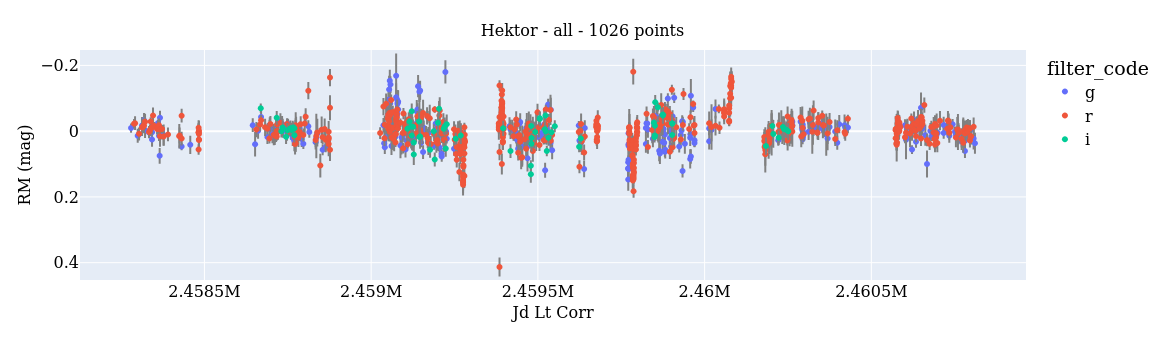

In [35]:
plots.general(x_column='jd_lt_corr',
              y_column='phase_corrected_mag',
              show_yerr=True,
              show_color=True,
              color_column='filter_code',
              table=merged_table_corr,
              save_path=string+'_corrected_by_phase_and_rotation_final.jpg')

# Another periodic signals?

Nothing above the significance level, except for the non-well subtracted points from orbit 3 and 5 that provide a period signal of 165 days, which is close to the interval between the most dense observations in each orbit.

In [36]:
rotational_analysis2 = spintrace.RotationalAnalysis(table=merged_table_corr, P_ref=(2.9651*24),f_min=0.001,f_max=12,n_term=2)
len(rotational_analysis2.table)

1026

In [37]:
a,b,c,d = rotational_analysis2.lomb_scargle_fit(
    asteroid='Skamandrios', 
    filter_code=None,
    use_magerr=True,
    save_path=string+'_Skamandrios_periodogram_broad.jpg',
    legend=True, 
    # samples_per_peak=400,
    peaks=True, 
    pn=2,
    y_max=0.2,
    n_shuffle=10,
    use_window_function=True,
    table=rotational_analysis2.table)

/home/flavia/.local/lib/python3.13/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:134: RuntimeWarning:

invalid value encountered in divide



1: Period = 23.924506 hours, Power = 0.137993
2: Period = 24.013419 hours, Power = 0.118711


In [53]:
dic = {'jd_lt_corr':'Time corrected by LT (JD)',
       'phase_angle':'Solar phase angle (deg)',
       'mag_cal':'PS1 magnitudes (mag)',
       'mag_cal_err': 'PS1 mag uncertainties (mag)',
       'filter_code': 'SDSS filter',
       'separation (mas)':'offset (mas)',
       'reduced_mag': 'initial reduced magnitudes (mag)',
       'mag_corr_by_rot': 'rotationally corrected reduced magnitudes',
       'phase_corrected_mag':'Hektor relative magnitude (mag)',
       'filename':'filename'
       }

In [54]:
residuals = merged_table_corr['phase_corrected_mag']

In [55]:
hektor = final_table.to_pandas()
hektor = hektor[['jd_lt_corr', 'phase_angle', 'mag_cal','mag_cal_err','filter_code',
                 'separation (mas)','reduced_mag','mag_corr_by_rot','phase_corrected_mag','filename']]
hektor.insert(9,'Residuals relative magnitude (mag)',residuals)
hektor = hektor.rename(columns=dic)
hektor.to_csv('Hektor_result.csv',index=False)